# SingleCell Data Analysis on the CPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 100, dpi_save = 300)
rcParams['figure.figsize'] = 10,10


## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata=sc.read("h5/adata.raw.h5ad")

CPU times: user 95.6 ms, sys: 102 ms, total: 197 ms
Wall time: 197 ms


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 0.2067570686340332


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('MT-') 

CPU times: user 5.03 ms, sys: 1.88 ms, total: 6.92 ms
Wall time: 6.83 ms


In [7]:
%%time
adata.var['RIBO'] = adata.var_names.str.startswith('RPS') 


CPU times: user 4.13 ms, sys: 0 ns, total: 4.13 ms
Wall time: 4.09 ms


In [8]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

CPU times: user 866 ms, sys: 43.8 ms, total: 910 ms
Wall time: 909 ms


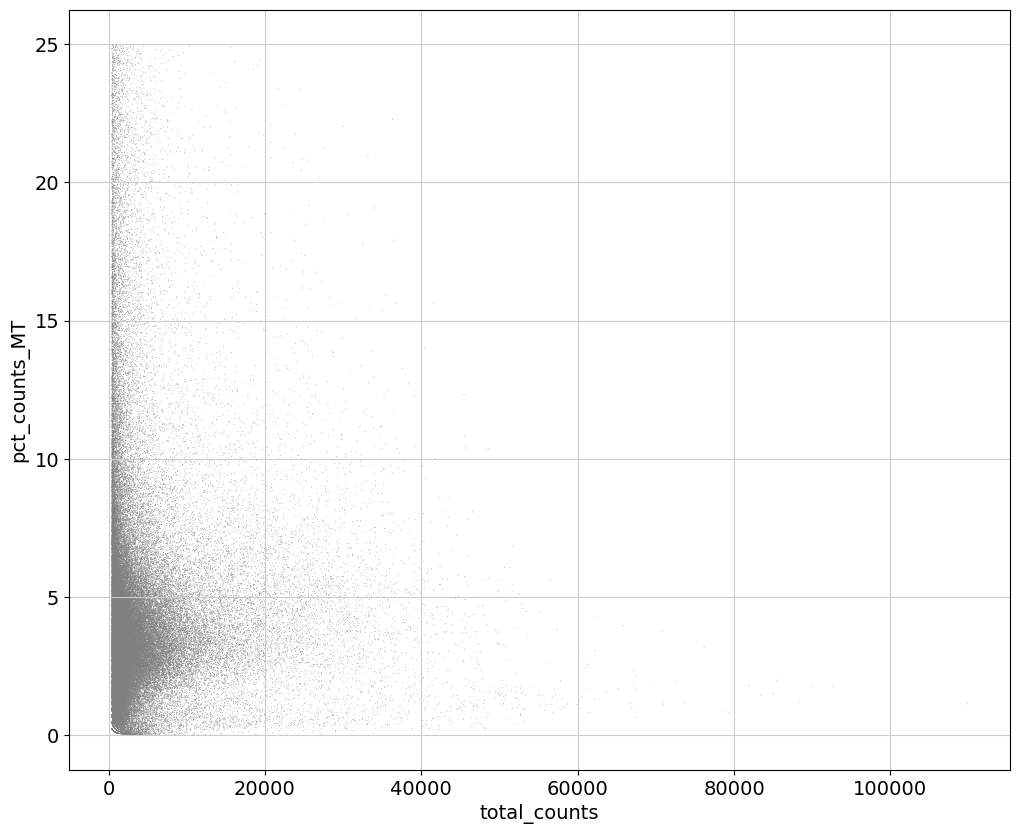

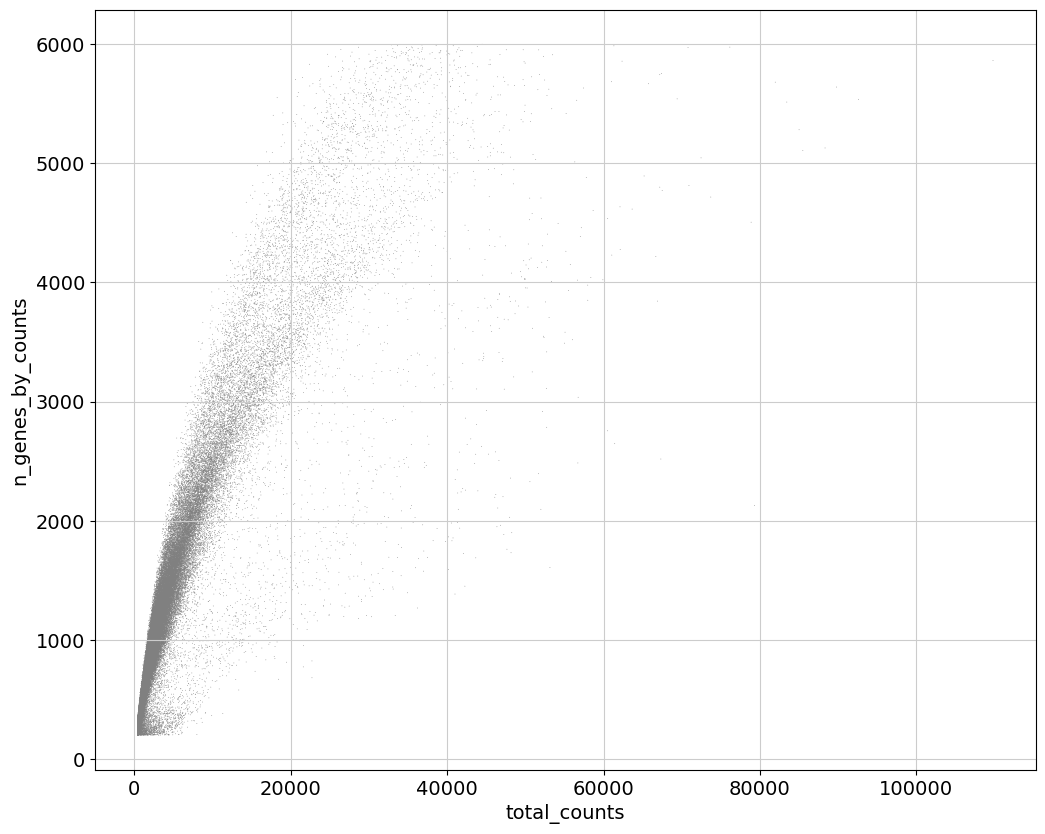

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

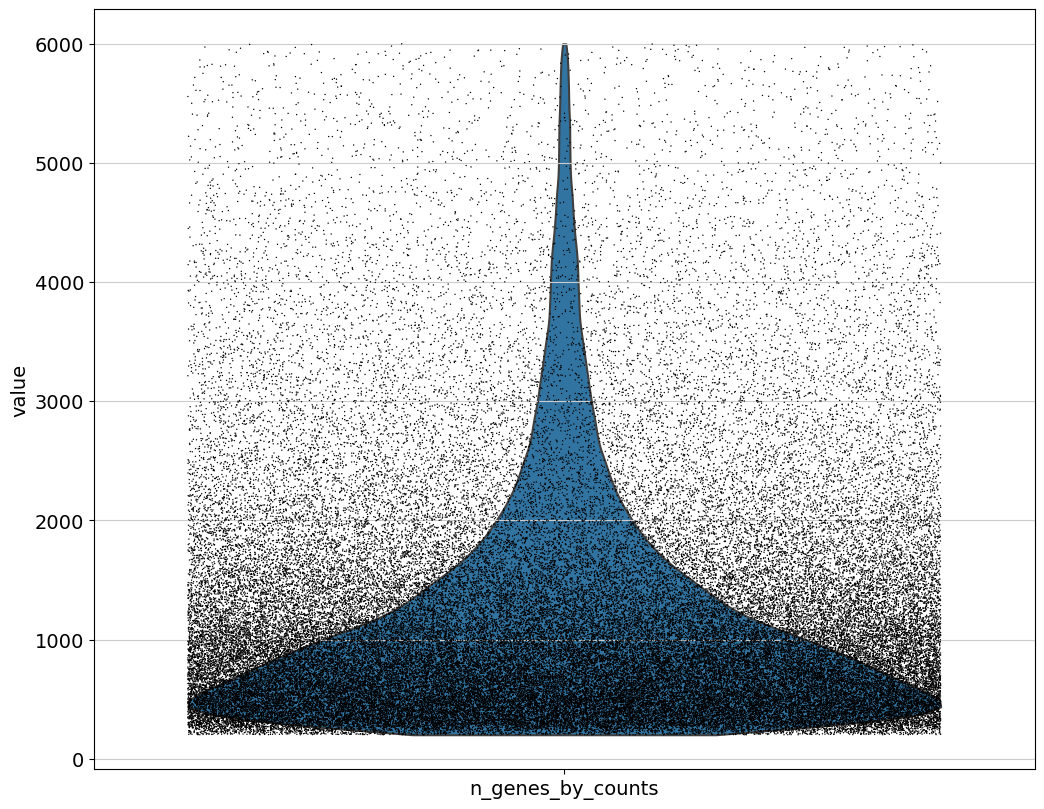

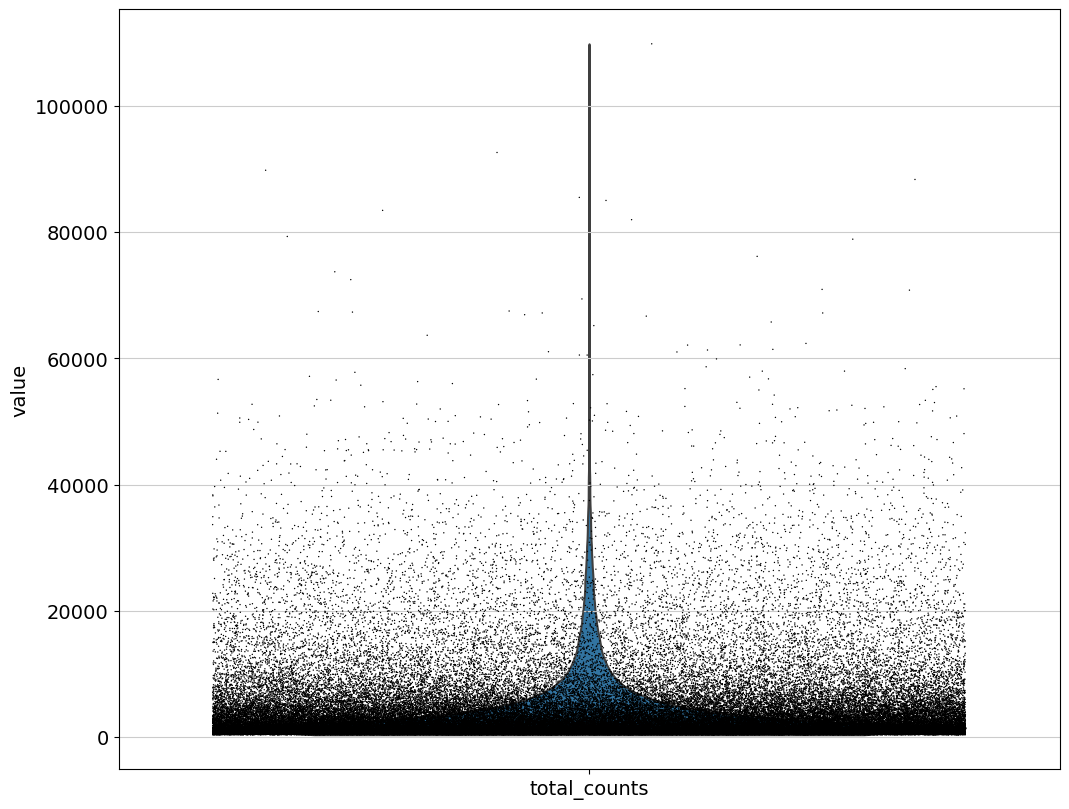

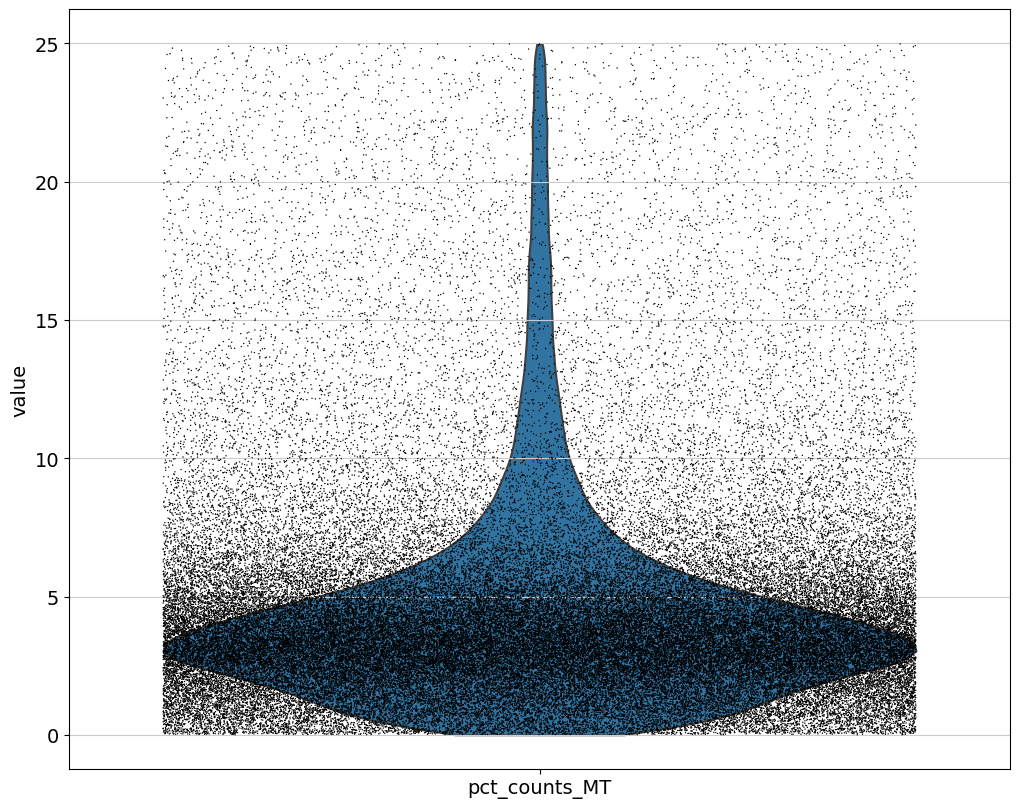

In [10]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, group_by="PatientNumber")
sc.pl.violin(adata, 'total_counts',jitter=0.4, group_by="PatientNumber")
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4, group_by="PatientNumber")


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

The size of our count matrix is now reduced.

In [11]:
%%time
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_MT < 20, :]

CPU times: user 16.6 ms, sys: 630 µs, total: 17.3 ms
Wall time: 16.4 ms


In [12]:
%%time
sc.pp.filter_genes(adata, min_cells=3)

Trying to set attribute `.var` of view, copying.


CPU times: user 681 ms, sys: 281 ms, total: 962 ms
Wall time: 962 ms


Some genes will now have zero expression in all cells. We filter out such genes.

In [13]:
adata.shape

(91180, 25365)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [14]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 254 ms, sys: 34.6 ms, total: 288 ms
Wall time: 288 ms


Next, we log transform the count matrix.

In [15]:
%%time
sc.pp.log1p(adata)

CPU times: user 820 ms, sys: 0 ns, total: 820 ms
Wall time: 820 ms


### Select Most Variable Genes

We will now select the most variable genes in the dataset.

In [16]:
%%time
sc.pp.highly_variable_genes(adata,batch_key="PatientNumber")

CPU times: user 2.57 s, sys: 242 ms, total: 2.81 s
Wall time: 2.81 s


Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use

In [17]:
%%time
adata.raw = adata

CPU times: user 43.9 ms, sys: 38.9 ms, total: 82.8 ms
Wall time: 82.3 ms


Restrict adata to only the highly variable genes

In [18]:
%%time
adata = adata[:, adata.var.highly_variable]

CPU times: user 50.6 ms, sys: 38.6 ms, total: 89.2 ms
Wall time: 88.8 ms


In [19]:
adata.shape

(91180, 2463)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [20]:
%%time
sc.pp.regress_out(adata,keys=["total_counts", "pct_counts_MT"])

CPU times: user 11min 25s, sys: 30min 23s, total: 41min 49s
Wall time: 1min 19s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [21]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 631 ms, sys: 74.9 ms, total: 706 ms
Wall time: 706 ms


We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [22]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 88.24550223350525


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [23]:
%%time
sc.tl.pca(adata, n_comps = 100)

CPU times: user 5min 43s, sys: 4min 30s, total: 10min 14s
Wall time: 20 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

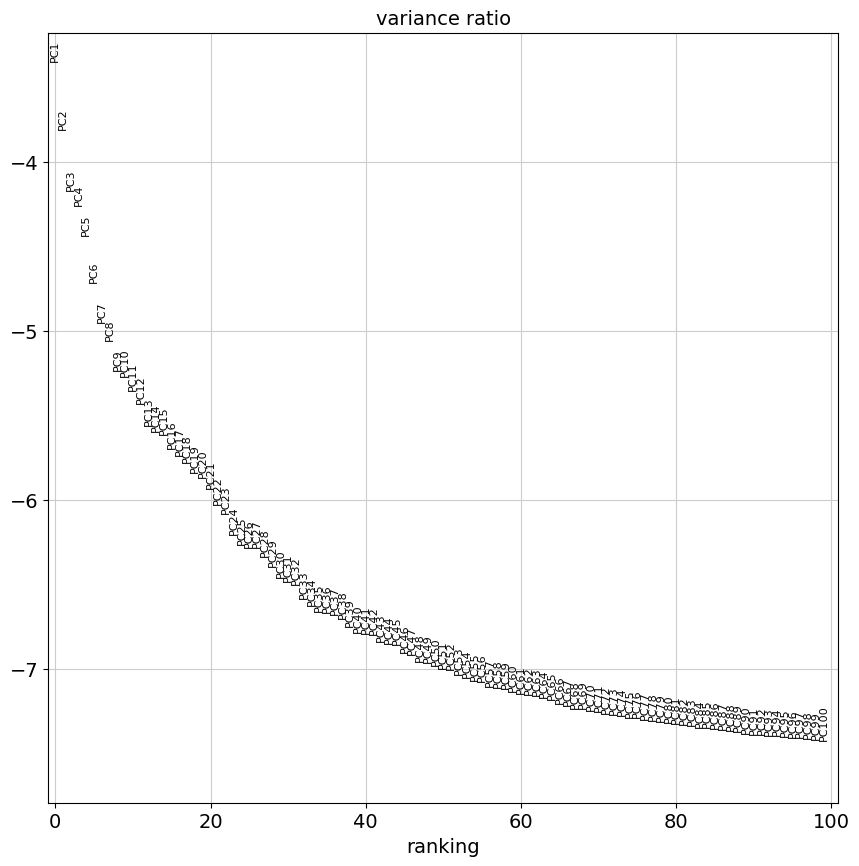

In [24]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [25]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 24.5 s, sys: 6.46 s, total: 31 s
Wall time: 13.9 s


In [26]:
%%time
sc.tl.umap(adata)

CPU times: user 2min 47s, sys: 1min 3s, total: 3min 51s
Wall time: 30.7 s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [27]:
%%time
sc.tl.louvain(adata)

CPU times: user 8.84 s, sys: 73.7 ms, total: 8.92 s
Wall time: 8.9 s


In [28]:
%%time
sc.tl.leiden(adata)

CPU times: user 10.1 s, sys: 88.4 ms, total: 10.2 s
Wall time: 10.2 s


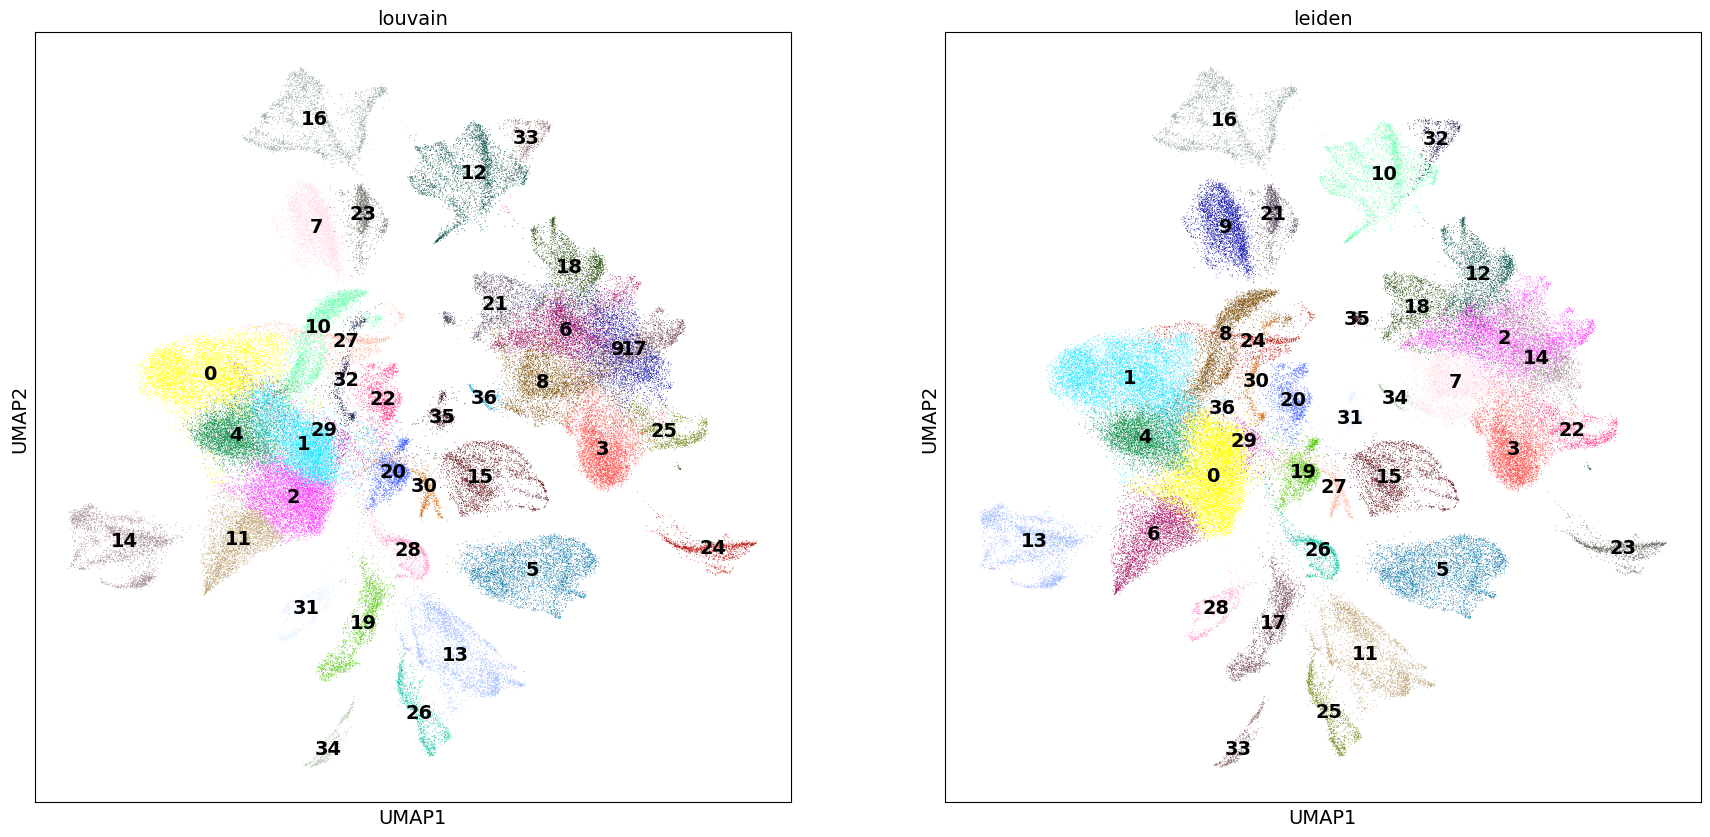

CPU times: user 626 ms, sys: 5.36 ms, total: 631 ms
Wall time: 631 ms


In [29]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

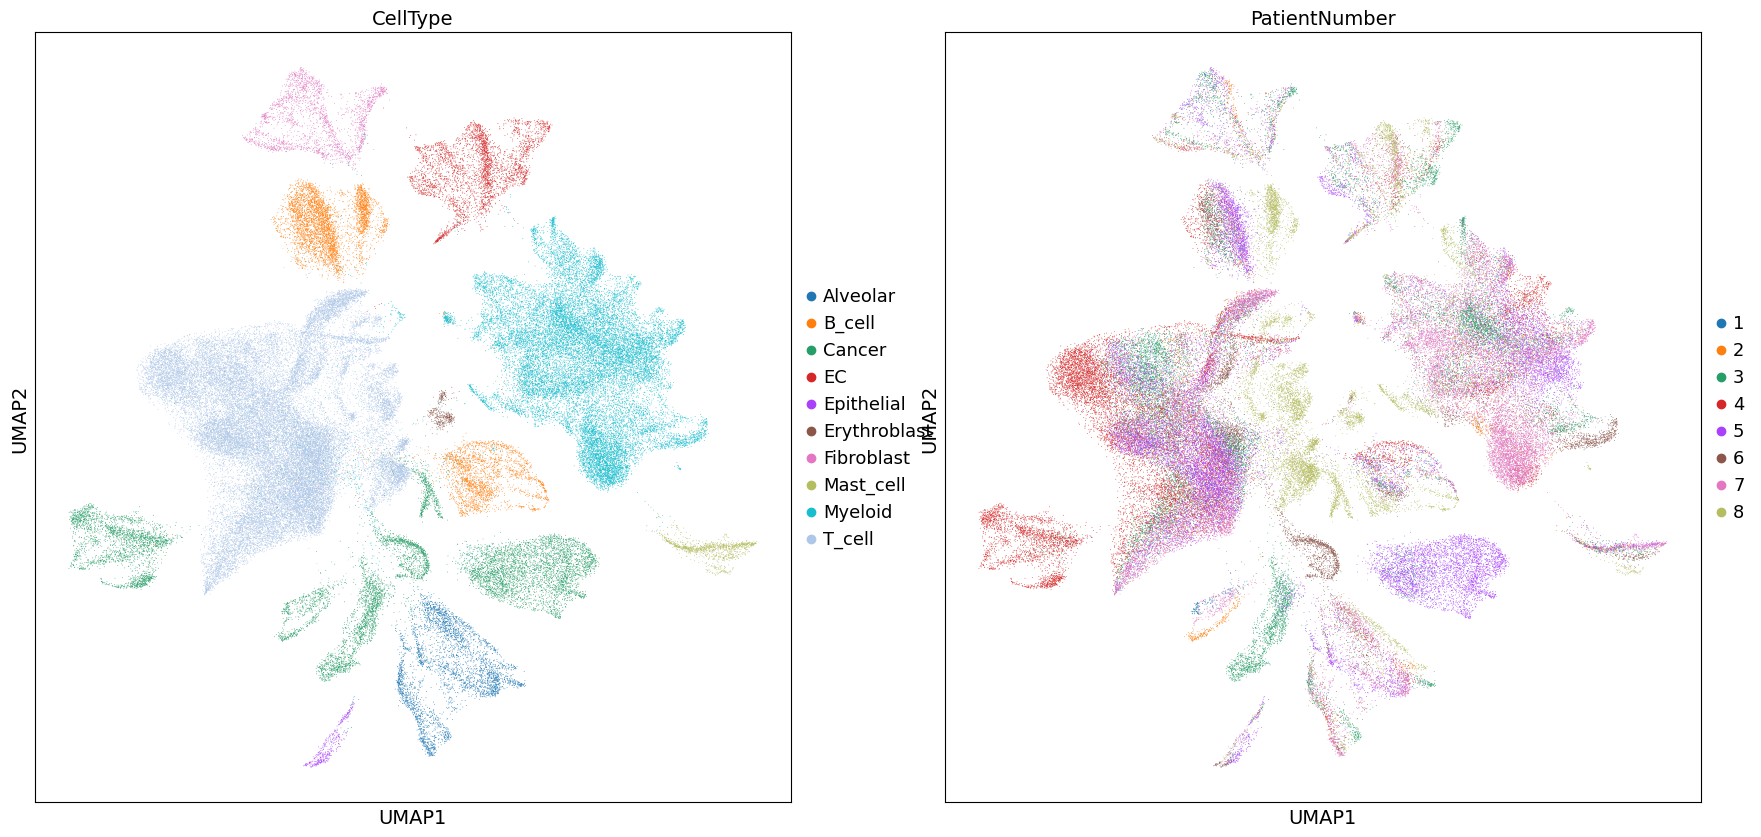

In [30]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + K-means
You might want to skip this step. Calucating a TSNE for 90000 cells takes really long 

In [31]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

In [32]:
%%time
sc.tl.tsne(adata, n_pcs = 40, n_jobs=-1)

CPU times: user 29min 34s, sys: 21min 16s, total: 50min 51s
Wall time: 3min 40s


... storing 'kmeans' as categorical


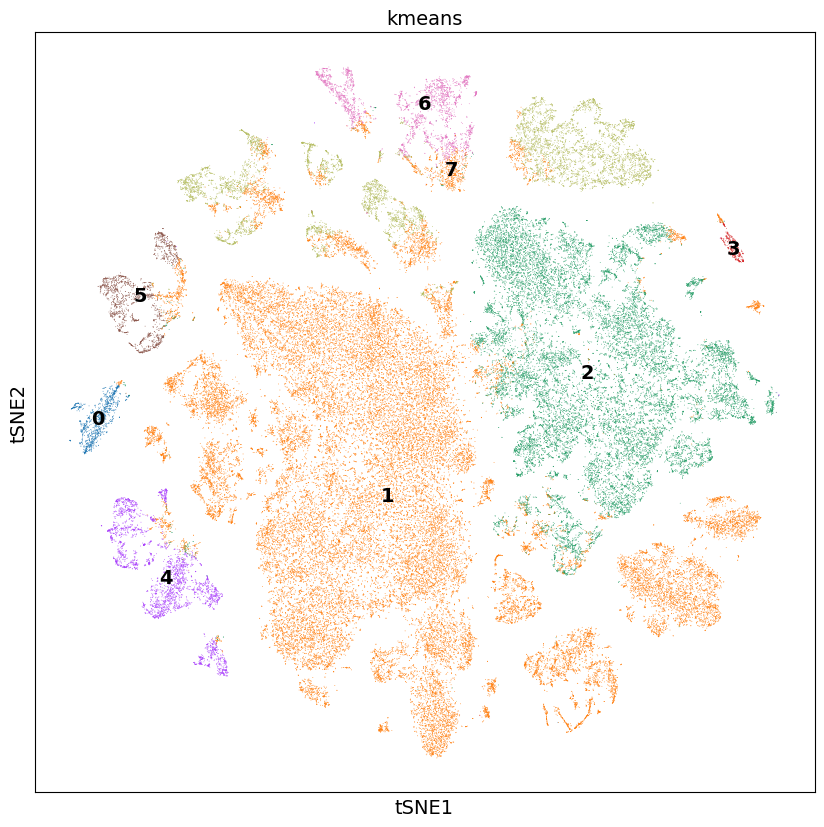

In [33]:
sc.pl.tsne(adata,color=["kmeans"], legend_loc='on data')

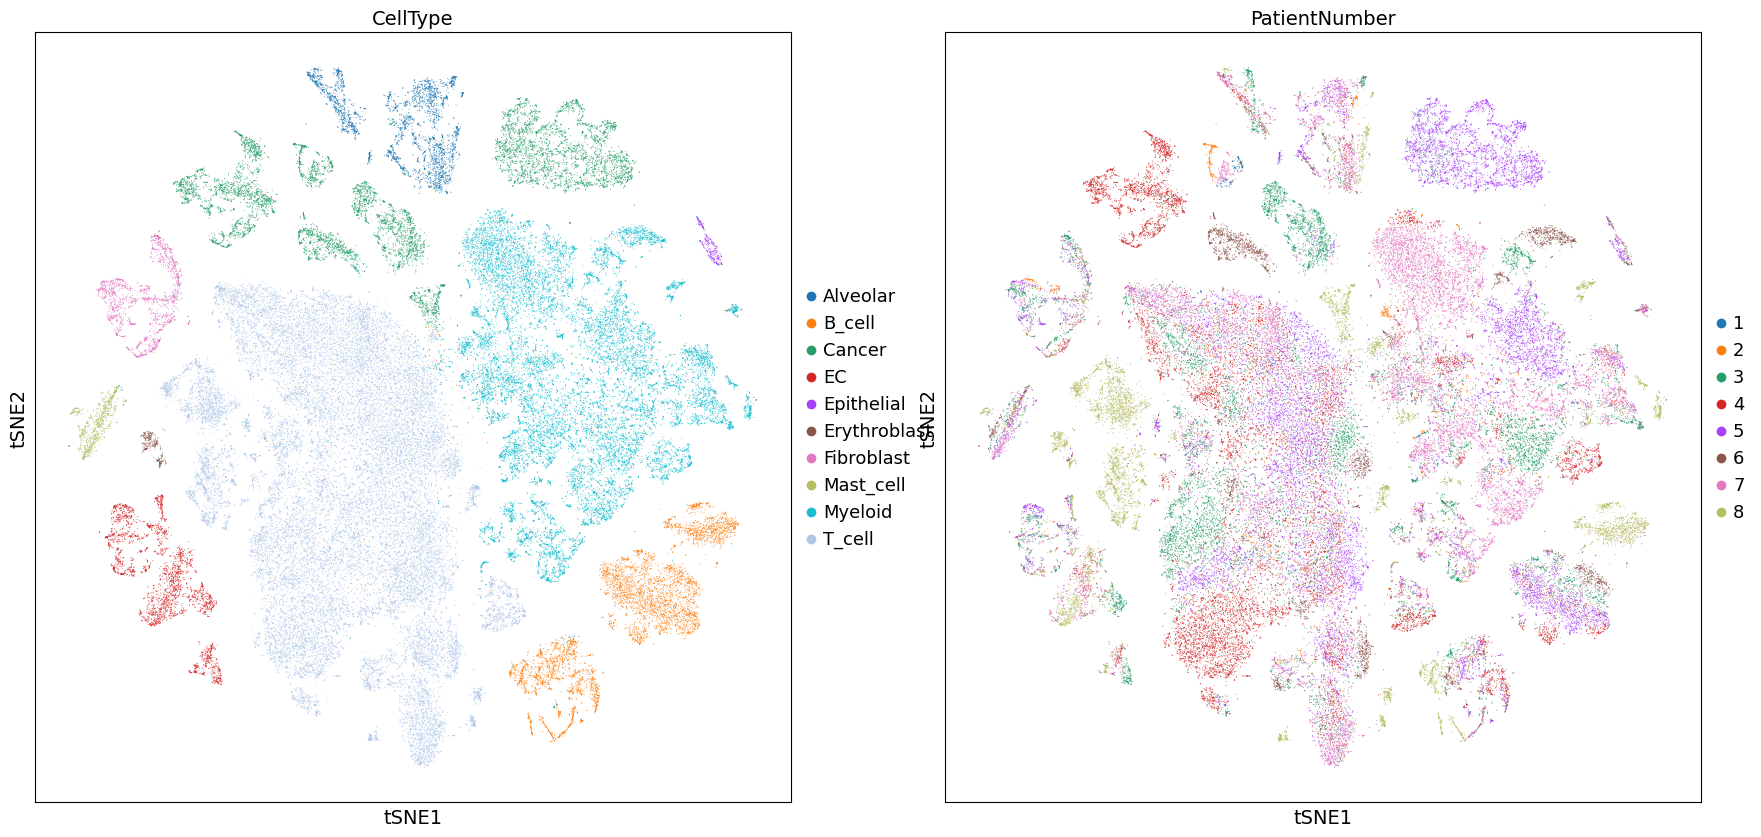

CPU times: user 722 ms, sys: 2.28 ms, total: 724 ms
Wall time: 724 ms


In [34]:
%%time
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [35]:
%%time
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg', use_raw=False)

CPU times: user 24min 41s, sys: 11min 23s, total: 36min 5s
Wall time: 1min 8s


/home/sdicks/miniconda3/envs/rapids-0.20_sc/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


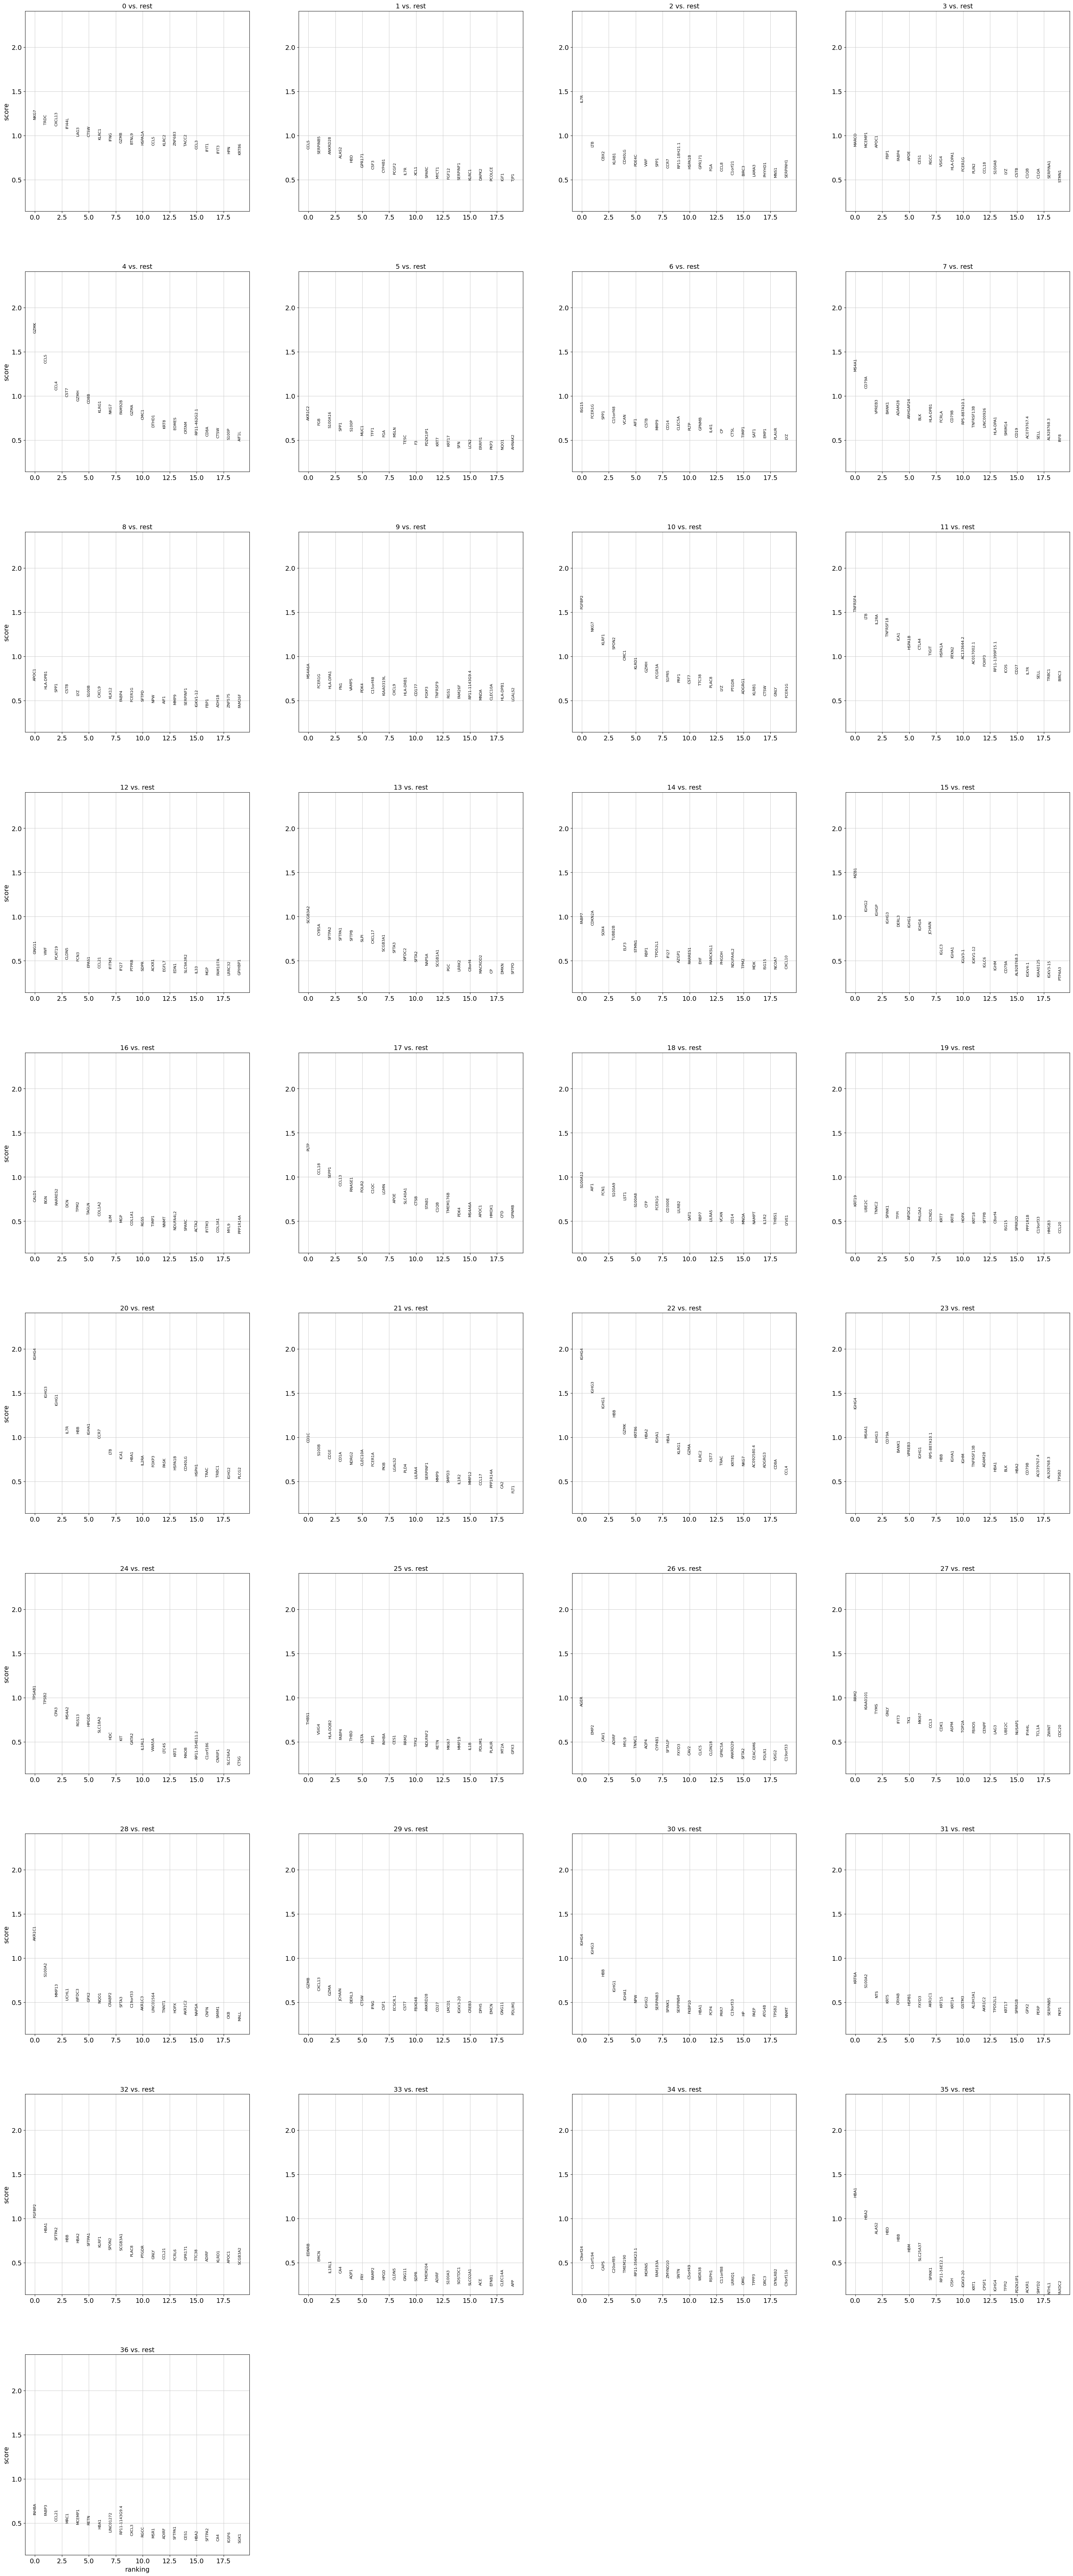

CPU times: user 3.32 s, sys: 114 ms, total: 3.43 s
Wall time: 3.43 s


In [36]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [37]:
post_time = time.time()

In [38]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 383.10807180404663


## Diffusion Maps

We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [39]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

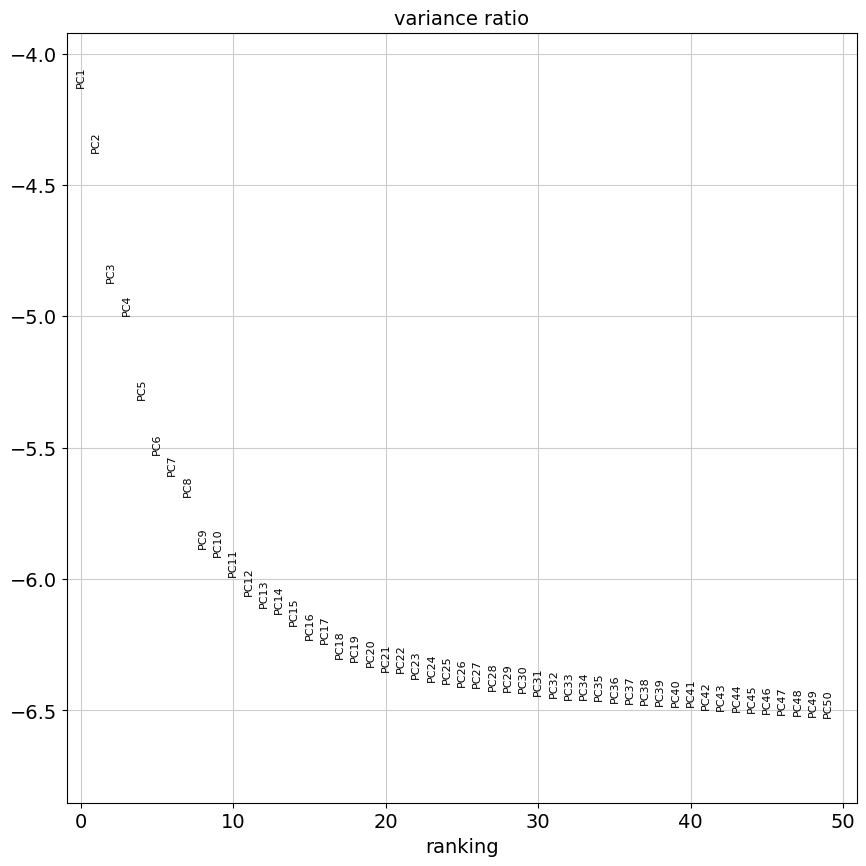

CPU times: user 2min 19s, sys: 1min 32s, total: 3min 52s
Wall time: 8.12 s


In [40]:
%%time
sc.pp.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [41]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
sc.tl.umap(tdata)
sc.tl.louvain(tdata)

CPU times: user 22.7 s, sys: 11.2 s, total: 33.9 s
Wall time: 14.4 s


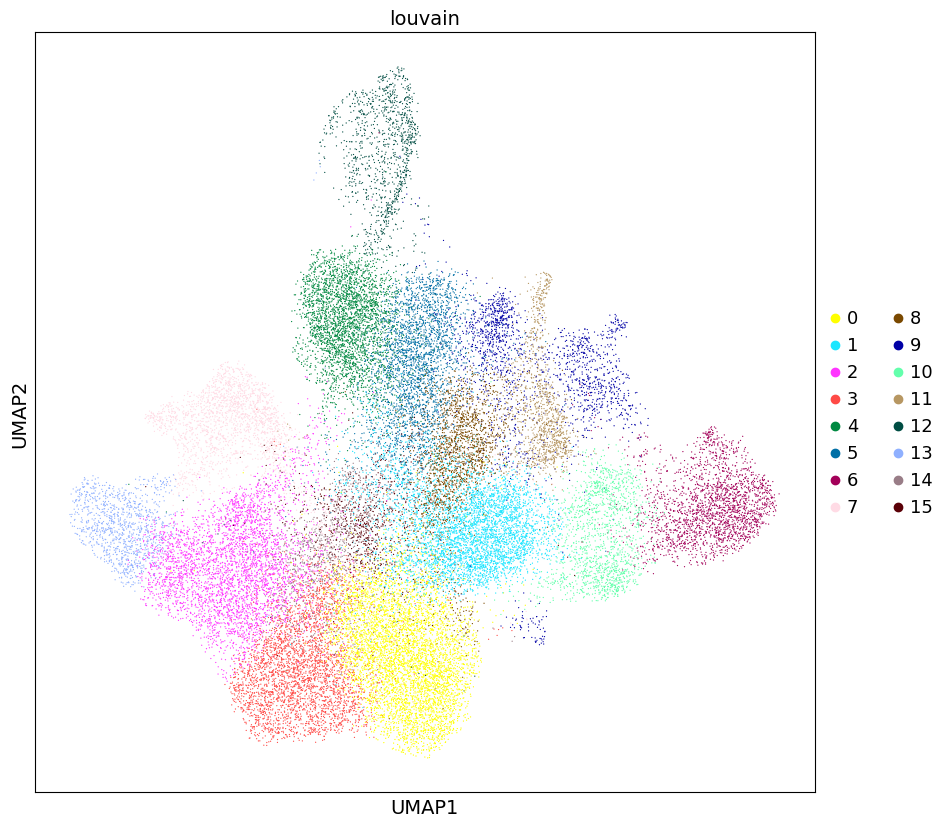

In [42]:
sc.pl.umap(tdata, color=["louvain"])

In [43]:
%%time
sc.tl.diffmap(tdata)

CPU times: user 5.65 s, sys: 11.7 s, total: 17.3 s
Wall time: 578 ms


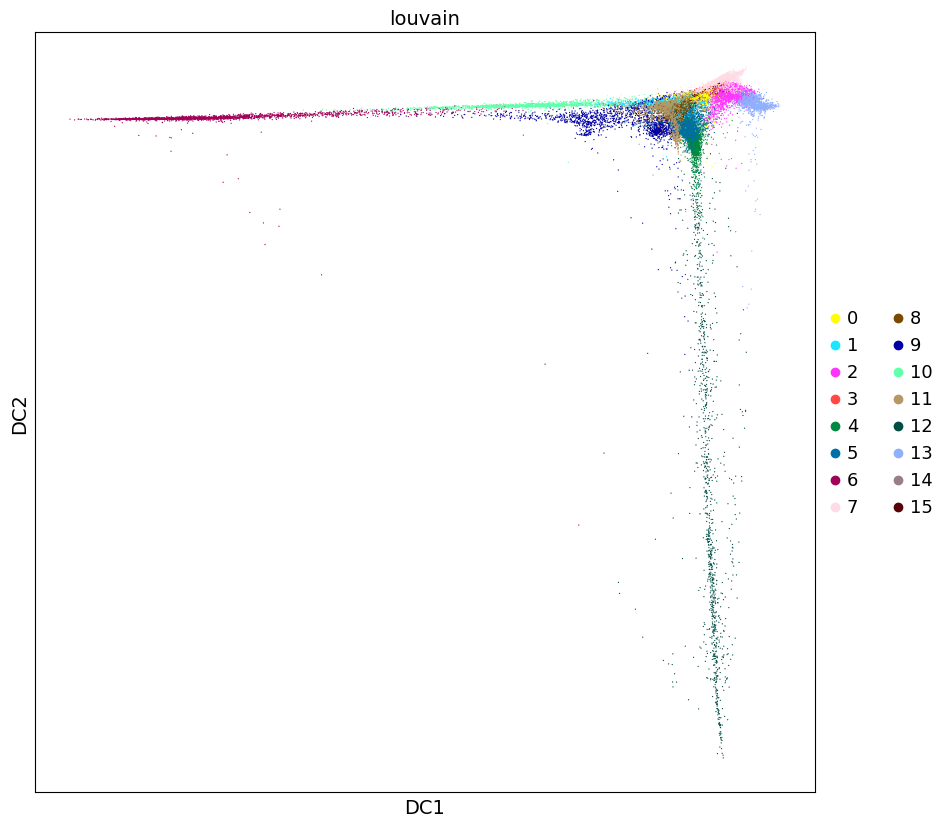

In [44]:
sc.pl.diffmap(tdata, color='louvain')

In [45]:
print("Total Preprocessing time: %s" % (time.time()-preprocess_start))

Total Preprocessing time: 495.1492087841034
